## Why Bayes?

Deep learning has dominated AI research in recent years^[See for example [this article](https://www.technologyreview.com/2019/01/25/1436/we-analyzed-16625-papers-to-figure-out-where-ai-is-headed-next/) in the MIT Technology Review] - but how much promise does it really hold? That is very much an ongoing and increasingly polarising debate that you can follow live on [Twitter](https://twitter.com/ilyasut/status/1491554478243258368). On one side you have optimists like Ilya Sutskever, chief scientist of OpenAI, who believes that large deep neural networks may already be slighty conscious - that's "may" and "slightly" and only if you just go deep enough? On the other side you have prominent sceptics like Judea Pearl who has long since argued that deep learning still boils down to curve fitting - purely associational and not even remotely intelligent [@pearl2018book].

Whatever side of this entertaining debate you find yourself on, the reality is that deep-learning systems have already been deployed at large scale both in academia and industry. More pressing debates therefore revolve around the trustworthiness of these existing systems. How robust are they and in what way exactly do they arrive at decisions that affect each and every one of us? Robustifying deep neural networks generally involves some form of adversarial training, which is costly, can hurt generalization [@raghunathan2019adversarial] and does ultimately not guarantee stability [@bastounis2021mathematics]. With respect to interpretability, surrogate explainers like LIME and SHAP are among the most popular tools, but they too have been shown to lack robustness [@slack2020fooling]. 

Exactly why are deep neural networks instable and intransparent? Let $\mathcal{D}=\{x,y\}_{n=1}^N$ denote our feature-label pairs and let $f(x;\theta)=y$ denote some deep neural network specified by its parameters $\theta$. Then the first thing to note is that the number of free parameters $\theta$ is typically huge (if you ask Mr Sutskever it really probably cannot be huge enough!). That alone makes it very hard to monitor and interpret the inner workings of deep-learning algorithms. Perhaps more importantly though, the number of parameters *relative* to the size of $\mathcal{D}$ is generally huge: 

> [...] deep neural networks are typically very underspecified by the available data, and [...] parameters [therefore] correspond to a diverse variety of compelling explanations for the data. 
> [@wilson2020case]

In other words, training a single deep neural network may (and usually does) lead to one random parameter specification that fits the underlying data very well. But in all likelihood there are many other specifications that also fit the data very well. This is both a strength and vulnerability of deep learning and very much calls for treating predictions from deep learning models probabilistically [@wilson2020case]. Formally, we are interested in estimating the posterior predictive distribution as the following Bayesian model average (BMA):

$$
p(y|x,\mathcal{D}) = \int p(y|x,\theta)p(\theta|\mathcal{D})d\theta
$$

The integral implies that we essentially need many predictions from many different specifications of $\theta$. Unfortunately, this means more work for us or rather our computers. Fortunately though, researchers have proposed many ingenious ways to approximate the equation above: @gal2016dropout propose using dropout at test time while @lakshminarayanan2016simple show that averaging over an ensemble of just five models seems to do the trick. Still, despite their simplicity and usefulness these approaches involve additional computational costs compared to training just a single network. As we shall see now though, another promising approach has recently entered the limelight: **Laplace approximation** (LA).

If you have read my [previous post](https://towardsdatascience.com/bayesian-logistic-regression-53df017ba90f) on Bayesian Logisitic Regression, then the term Laplace should already sound familiar to you. As a matter of fact, we will see that all concepts covered in that previous post can be naturally extended to deep learning. While some of these concepts will be revisited below, I strongly recommend you check out the previous post before reading on here. Without further ado let us now see how LA can be used for truly effortless deep learning.

## Laplace Approximation

While LA was first proposed in the 18th century, it has so far not attracted serious attention from the deep learning community largely because it involves a possibly large Hessian computation. @daxberger2021laplace are on a mission to change the perception that LA has no use in DL: in their [NeurIPS 2021 paper](https://arxiv.org/pdf/2106.14806.pdf) they demonstrate empirically that LA can be used to produce Bayesian model averages that are at least at par with existing approaches in terms of uncertainty quantification and out-of-distribution detection. They show that recent advancements in autodifferentation can be leveraged to produce fast and accurate approximations of the Hessian and even provide a fully-fledged [Python library](https://aleximmer.github.io/Laplace/) that can be used with any pretrained Torch model. For this post, I have built a much less comprehensive, pure-play equivalent of their package in Julia - [BayesLaplace.jl](https://www.paltmeyer.com/BayesLaplace.jl/dev/) can be used with deep learning models built in [Flux.jl](https://fluxml.ai/), which is Julia's main DL library. As in the previous post on Bayesian logistic regression I will rely on Julia code snippits instead of equations to convey the underlying maths. If you're curious about the maths, the [NeurIPS 2021 paper](https://arxiv.org/pdf/2106.14806.pdf) provides all the detail you need.

### From Bayesian Logisitic Regression ...

Let's recap: in the case of logisitic regression we had a assumed a zero-mean Gaussian prior $p(\mathbf{w}) \sim \mathcal{N} \left( \mathbf{w} | \mathbf{0}, \sigma_0^2 \mathbf{I} \right)=\mathcal{N} \left( \mathbf{w} | \mathbf{0}, \mathbf{H}_0^{-1} \right)$ for the weights that are used to compute logits $\mu_n=\mathbf{w}^T\mathbf{x}_n$, which in turn are fed to a sigmoid function to produce probabilities $p(y_n=1)=\sigma(\mu_n)$. We saw that under this assumption solving the logisitic regression problem corresponds to minimizing the following differentiable loss function:

$$
\ell(\mathbf{w})=- \sum_{n=1}^{N} [y_n \log \mu_n + (1-y_n)\log (1-\mu_n)] + \frac{1}{2} (\mathbf{w}-\mathbf{w}_0)^T\mathbf{H}_0(\mathbf{w}-\mathbf{w}_0)
$$

As our first step towards Bayesian deep learning, we observe the following: the loss function above corresponds to the objective faced by a single-layer artificial neural network with sigmoid activation and weight decay^[See this [answer] on Stack Exchange for a detailed discussion.]. In other words, regularized logisitic regression is equivalent to a very simple neural network architecture and hence it is not surprising that underlying concepts can in theory be applied in much the same way. 

So let's quickly recap the next core concept: LA relies on the fact that the second-order Taylor expansion of our loss function $\ell$ evaluated at the **maximum a posteriori** (MAP) estimate $\hat{\mathbf{w}}=\arg\max_{\mathbf{w}} p(\mathbf{w}|\mathcal{D})$ amounts to a multi-variate Gaussian distribution. In particular, that Gaussian is centered around the MAP estimate with covariance equal to the inverse Hessian evaluated at the mode $\hat{\Sigma}=(\mathbf{H}(\hat{\mathbf{w}}))^{-1}$ [@murphy2022probabilistic]. 

That is basically all there is to the story: if we have a good estimate of $\mathbf{H}(\hat{\mathbf{w}})$ we have an analytical expression for an (approximate) posterior over parameters. So let's go ahead and start by run Bayesian logisitic regression using [Flux.jl](https://fluxml.ai/). We begin by loading some required packages including [BayesLaplace.jl](https://www.paltmeyer.com/BayesLaplace.jl/dev/). It ships with a helper function `toy_data_linear` that creates a toy data set composed of linearly separable samples evenly balanced across the two classes.

In [1]:
# Import libraries.
using Flux, Plots, Random, PlotThemes, Statistics, BayesLaplace
theme(:juno)
# Number of points to generate.
xs, y = toy_data_linear(100)
X = hcat(xs...); # bring into tabular format
data = zip(xs,y);

Then we proceed to prepare the single-layer neural network with weight decay. The term $\lambda$ determines the strength of the $\ell2$ penalty: we regularize parameters $\theta$ more heavily for higher values. Equivalently, we can say that from the Bayesian perspective it governs the strength of the prior $p(\theta) \sim \mathcal{N} \left( \theta | \mathbf{0}, \sigma_0^2 \mathbf{I} \right)= \mathcal{N} \left( \mathbf{w} | \mathbf{0}, \lambda_0^{-2} \mathbf{I} \right)$: a higher value of $\lambda$ indicates a higher conviction about our prior belief that $\theta=\mathbf{0}$, which is of course equivalent to regularizing more heavily. The exact choice of $\lambda=0.5$ for this toy example is somewhat arbitrary (it made for good visualizations below). Note that I have used $\theta$ to denote our neural parameters to distinguish the case from Bayesian logisitic regression, but we are in fact still solving the same problem.

In [2]:
nn = Chain(Dense(2,1))
λ = 0.5
sqnorm(x) = sum(abs2, x)
weight_regularization(λ=λ) = 1/2 * λ^2 * sum(sqnorm, Flux.params(nn))
loss(x, y) = Flux.Losses.logitbinarycrossentropy(nn(x), y) + weight_regularization()

loss (generic function with 1 method)

Before we apply Laplace approximation we train our model:

In [3]:
using Flux.Optimise: update!, ADAM
opt = ADAM()
epochs = 50

for epoch = 1:epochs
  for d in data
    gs = gradient(params(nn)) do
      l = loss(d...)
    end
    update!(opt, params(nn), gs)
  end
end

Up until this point we have just followed the standard recipe for training a regularized artificial neural network in [Flux.jl](https://fluxml.ai/) for a simple binary classification task. To compute the Laplace approximation using [BayesLaplace.jl](https://www.paltmeyer.com/BayesLaplace.jl/dev/) we need just two more lines of code:

In [4]:
la = laplace(nn, λ=λ)
fit!(la, data);

Under the hood the Hessian is approximated through the **empirical Fisher**, which can be computed using only the gradients of our loss function $\nabla_{\theta}\ell(f(\mathbf{x}_n;\theta,y_n))$ where $\{\mathbf{x}_n,y_n\}$ are training data (see [NeurIPS 2021 paper](https://arxiv.org/pdf/2106.14806.pdf) for details). Finally, [BayesLaplace.jl](https://www.paltmeyer.com/BayesLaplace.jl/dev/) ships with a function `predict(𝑳::LaplaceRedux, X::AbstractArray; link_approx=:probit)` that computes the posterior predictive using a probit approximation, much like we saw in the previous post. That function is used under the hood of the `plot_contour` function below to create the right panel of Figure @fig-logit. It visualizes the posterior predictive distribution in the 2D feature space. For comparison I have added the corresponding plugin estimate as well. Note how for the Laplace approximation the predicticted probabilities fan out indicating that confidence decrease in regions scarce of data.

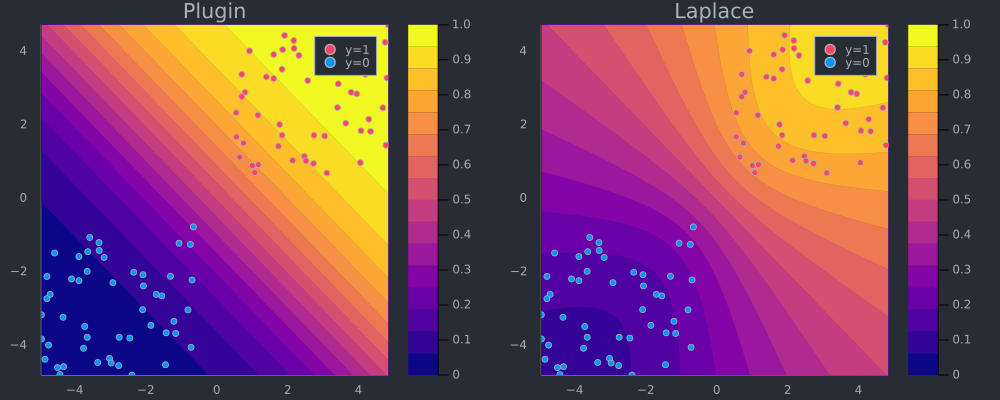

In [7]:
#| label: fig-logit
#| fig-cap: Posterior predictive distribution of logisitic regression in the 2D feature space using plugin estimator (left) and Laplace approximation (right).
p_plugin = plot_contour(X',y,la;title="Plugin",type=:plugin);
p_laplace = plot_contour(X',y,la;title="Laplace")
# Plot the posterior distribution with a contour plot.
plot(p_plugin, p_laplace, layout=(1,2), size=(1000,400))

### ... to Bayesian Neural Networks

Now let's step it up a notch: we will repeat the exercise from above, but this time for data that is not linearly separable using a simple MLP instead of the single-layer neural network we used above. The code below is almost the same as above, so I will not go through the various steps again. 

In [8]:
# Number of points to generate:
xs, y = toy_data_non_linear(200)
X = hcat(xs...); # bring into tabular format
data = zip(xs,y)

# Build MLP:
n_hidden = 32
D = size(X)[1]
nn = Chain(
    Dense(D, n_hidden, σ),
    Dense(n_hidden, 1)
)  
λ = 0.01
sqnorm(x) = sum(abs2, x)
weight_regularization(λ=λ) = 1/2 * λ^2 * sum(sqnorm, Flux.params(nn))
loss(x, y) = Flux.Losses.logitbinarycrossentropy(nn(x), y) + weight_regularization()

# Training:
epochs = 200
for epoch = 1:epochs
  for d in data
    gs = gradient(params(nn)) do
      l = loss(d...)
    end
    update!(opt, params(nn), gs)
  end
end

Fitting the Laplace approximation is also analogous, but note that this we have added an argument: `subset_of_weights=:last_layer`. This specifies that we only want to use the parameters of the last layer of our MLP. While we could have used all of them (`subset_of_weights=:all`), @daxberger2021laplace find that the last-layer Laplace approximation produces satisfying results, while be computationally cheaper. Figure @fig-mlp demonstrates that once again the Laplace approximation yields a posterior predictive distribution that is more conservative than the over-confident plugin estimate.

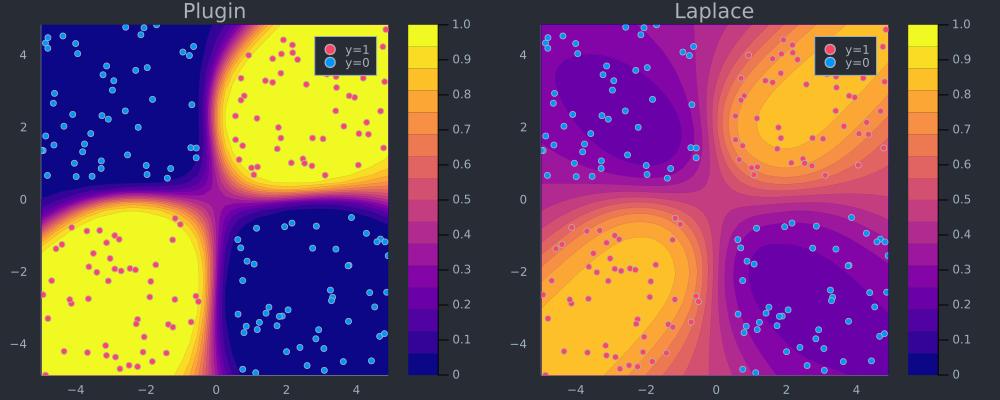

In [9]:
#| label: fig-mlp
#| fig-cap: Posterior predictive distribution of a simple MLP in the 2D feature space using plugin estimator (left) and Laplace approximation (right).
la = laplace(nn, λ=λ, subset_of_weights=:last_layer)
fit!(la, data);
p_plugin = plot_contour(X',y,la;title="Plugin",type=:plugin)
p_laplace = plot_contour(X',y,la;title="Laplace")
# Plot the posterior distribution with a contour plot.
plot(p_plugin, p_laplace, layout=(1,2), size=(1000,400))

To see why this is a desirable outcome consider the zoomed out version of Figure @fig-mlp below: the plugin estimator classifies with full confidence in regions completely scarce of any data. Arguably Laplace approximation produces a much more reasonable picture, even though it too could likely be improved by fine-tuning our choice of $\lambda$ and the neural network architecture.

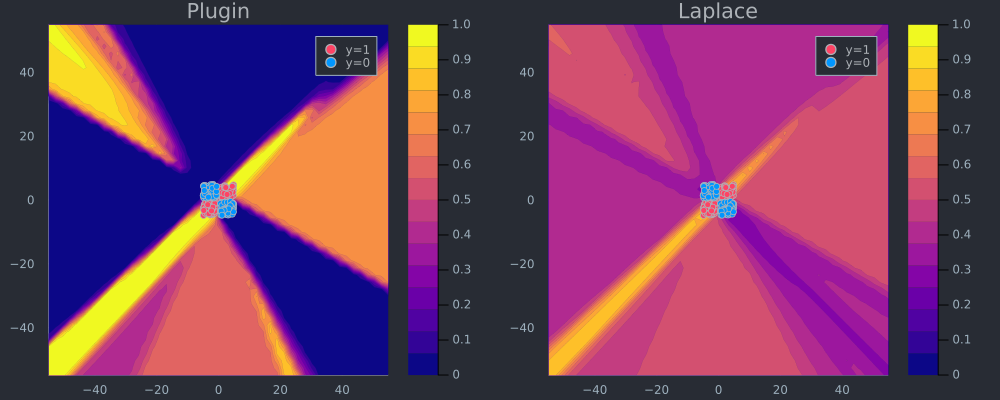

In [10]:
#| label: fig-mlp-zoom
#| fig-cap: Posterior predictive distribution of a simple MLP in the 2D feature space using plugin estimator (left) and Laplace approximation (right). Zoomed out.
zoom=-50
p_plugin = plot_contour(X',y,la;title="Plugin",type=:plugin,zoom=zoom);
p_laplace = plot_contour(X',y,la;title="Laplace",zoom=zoom);
# Plot the posterior distribution with a contour plot.
plot(p_plugin, p_laplace, layout=(1,2), size=(1000,400))

## Wrapping up

The case for Bayesian Deep Learning is strong: ...

## References